In [3]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import modin.pandas as md
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from model_settings import ms
os.chdir(os.path.abspath(str(Path())))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
notebook_dir = str(Path().resolve())
sys.path.append(os.path.join(notebook_dir,'historical_data','historical_generation'))
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")


##################
# training start #
##################

Sat Oct 19 12:27:00 2024



# Loading data

In [14]:
filespath = os.path.join(notebook_dir,'asian_option_generation','historical_asian_options')

files = [file for file in os.listdir(filespath) if file.endswith('.csv')]
dfs = []
for file in files:
    dfs.append(pd.read_csv(os.path.join(filespath,file)))
    
try:
    dataset = pd.concat(dfs,ignore_index=True).iloc[:,1:]
except Exception as e:
    print(e)
    pass

No objects to concatenate


In [5]:
from model_settings import vanilla_pricer
vanillas = vanilla_pricer.vanilla_pricer()
dataset['calculation_date'] = pd.to_datetime(dataset['calculation_date'],format='%Y-%m-%d')
dataset.dtypes

vanilla option pricer initialized


spot_price                 float64
strike_price                 int64
risk_free_rate             float64
dividend_rate              float64
w                           object
averaging_type              object
fixing_frequency             int64
n_fixings                    int64
past_fixings                 int64
kappa                      float64
theta                      float64
rho                        float64
eta                        float64
v0                         float64
calculation_date    datetime64[ns]
days_to_maturity             int64
asian_price                float64
dtype: object

In [6]:
dataset.loc[:,'vanilla'] = vanillas.df_heston_price(dataset)
dataset.loc[:,'difference'] = dataset['vanilla'] -  dataset['asian_price']
dataset.loc[:,'moneyness'] = ms.vmoneyness(dataset['spot_price'],dataset['strike_price'],dataset['w'])
dataset

,spot_price,strike_price,risk_free_rate,dividend_rate,w,averaging_type,fixing_frequency,n_fixings,past_fixings,kappa,theta,rho,eta,v0,calculation_date,days_to_maturity,asian_price,vanilla,difference,moneyness
0,573.17000,286,0.04000,0.00000,call,arithmetic,90,1,0,0.54624,0.12108,-0.72987,1.31817,0.03866,2024-10-08,90,287.01254,290.07426,3.06172,1.00409
1,573.17000,286,0.04000,0.00000,call,geometric,90,1,0,0.54624,0.12108,-0.72987,1.31817,0.03866,2024-10-08,90,286.64037,290.07426,3.43389,1.00409
2,573.17000,286,0.04000,0.00000,put,arithmetic,90,1,0,0.54624,0.12108,-0.72987,1.31817,0.03866,2024-10-08,90,0.00000,0.09730,0.09730,-0.50102
3,573.17000,286,0.04000,0.00000,put,geometric,90,1,0,0.54624,0.12108,-0.72987,1.31817,0.03866,2024-10-08,90,0.00000,0.09730,0.09730,-0.50102
4,573.17000,298,0.04000,0.00000,call,arithmetic,90,1,0,0.54624,0.12108,-0.72987,1.31817,0.03866,2024-10-08,90,275.48352,278.22490,2.74138,0.92339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,582.35000,861,0.04000,0.00000,put,geometric,90,1,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,90,273.58131,270.20497,-3.37634,0.47849
1596,582.35000,873,0.04000,0.00000,call,arithmetic,90,1,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,90,0.00000,0.00420,0.00420,-0.33293
1597,582.35000,873,0.04000,0.00000,call,geometric,90,1,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,90,0.00000,0.00420,0.00420,-0.33293
1598,582.35000,873,0.04000,0.00000,put,arithmetic,90,1,0,4.77644,0.04654,-0.72834,2.49610,0.03890,2024-10-17,90,284.79074,282.08611,-2.70463,0.49910


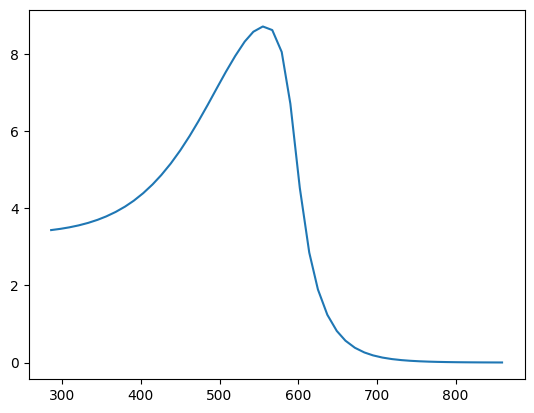

In [12]:
maturities = np.sort(np.array(dataset['days_to_maturity'].unique().tolist()))
strikes = np.sort(np.array(dataset['strike_price'].unique().tolist()))
spots = np.sort(np.array(dataset['spot_price'].unique().tolist()))
dates = np.sort(np.array(dataset['calculation_date'].unique().tolist()))
test = dataset.copy()
test = test[
        (test['averaging_type']=='geometric')&
        (test['n_fixings']==1)&
        (test['calculation_date']==dates[0])
].sort_values(by=['strike_price'])

test_puts = test[(test['w'] == 'put')][['strike_price','difference']].sort_values(by='strike_price').set_index('strike_price')
test_calls = test[(test['w'] == 'call')][['strike_price','difference']].sort_values(by='strike_price').set_index('strike_price')
plt.figure()
plt.plot(test_calls)

# Preprocessing

In [ ]:
ls = [1, 2, 3]
ls2 = [1]

ls3 = ls2 + 

In [ ]:
import convsklearn
categorical_features = ['averaging_type', 'w']
numerical_features = [
    'spot_price',
    'strike_price',
    'days_to_maturity',
    'risk_free_rate',
    'dividend_rate',
    'kappa',
    'theta',
    'rho',
    'eta',
    'v0',
    'fixing_frequency',
    'n_fixings',
    'past_fixings'
]
target_name = 'observed_price'
trainer = convsklearn.convsklearn(categorical_features = categorical_features, numerical_features = numerical_features, target_name = target_name)
for col in trainer.numerical_features:
    dataset[col] = pd.to_numeric(dataset[col],errors='coerce')
dataset['asian_price'] = pd.to_numeric(dataset['asian_price'],errors='coerce')
dataset['observed_price'] = ms.noisyfier(dataset['asian_price'])

## Train/test split

In [ ]:
unique_dates = dataset['calculation_date'].sort_values(
    ascending=True).unique().tolist()
filter_date = unique_dates[int(0.85*len(unique_dates))]
train_data = dataset[
    (
      # (dataset['calculation_date']>=datetime(2007,1,1))
      #  &
      (dataset['calculation_date']<=filter_date)
    )
].copy()

test_data = dataset[
    (
        (dataset['calculation_date']>filter_date)
        # &
        # (dataset['calculation_date']<=datetime(2012,12,31))
    )
].copy()

test_train_ratio = int(round(100*test_data.shape[0]/train_data.shape[0],0))
print(f"train/test: {100-test_train_ratio}/{test_train_ratio}")

In [ ]:
arrs = trainer.get_train_test_arrays(
    train_data, test_data,feature_set = trainer.feature_set, target_name=trainer.target_name)
preprocessor = trainer.preprocess()
train_X = arrs['train_X'] 
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['test_y']

# Training

In [ ]:
model_fit, runtime, specs = trainer.run_dnn(preprocessor,train_X,train_y)
train_end = time.time()
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

# Testing

In [ ]:
test_data.describe()

In [ ]:
insample, outsample, errors = trainer.test_prediction_accuracy(
        model_fit,
        test_data,
        train_data
        )
outofsample_RMSE = errors['outofsample_RMSE']

# Saving

In [ ]:
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H-%M-%S"))
file_tag = str(train_end_tag + " " + specs[0] + " " + str(int(outofsample_RMSE)) + "RMSE")
os.chdir(os.path.join(notebook_dir,'trained_models'))
files_dir = os.path.join(
    notebook_dir,'trained_models','trained_models',
    file_tag)

if Path(files_dir).exists():
    pass
else:
    os.mkdir(files_dir)

file_dir = os.path.join(files_dir,file_tag)

S = np.sort(train_data['spot_price'].unique())
K = np.sort(train_data['strike_price'].unique())
T = np.sort(train_data['days_to_maturity'].unique())
W = np.sort(train_data['w'].unique())
n_calls = train_data[train_data['w']=='call'].shape[0]
n_puts = train_data[train_data['w']=='put'].shape[0]
insample.to_csv(f"{file_dir} insample.csv")
outsample.to_csv(f"{file_dir} outsample.csv")
joblib.dump(model_fit,str(f"{file_dir}.pkl"))
pd.set_option("display.max_columns",None)

with open(f'{file_dir}.txt', 'w') as file:
    file.write(train_start_tag)
    file.write(f"\nspot(s):\n{S}")
    file.write(f"\n\nstrikes:\n{K}\n")
    file.write(f"\nmaturities:\n{T}\n")
    file.write(f"\ntypes:\n{W}\n")
    try:
        file.write(f"\n{train_data['barrier_type_name'].unique()}")
    except Exception:
        pass
    try:
        for col in ['averaging_type','fixing_frequency','past_fixings','n_fixings']:
            file.write(f"\n{col}:")
            file.write(f"\n{dataset[col].drop_duplicates().sort_values().values}\n")
    except Exception as e:
        print(e)
        pass
    file.write(f"\nnumber of calls, puts:\n{n_calls},{n_puts}\n")
    file.write(f"\ntotal prices:\n{train_data.shape[0]}\n")
    for spec in specs:
        file.write(f"{spec}\n")
    file.write("#"*17+"\n# training data #\n"+"#"*17+
          f"\n{train_data.describe()}\n")
    file.write("#"*13+"\n# test data #\n"+"#"*13+
          f"\n{test_data.describe()}\n")
    file.write(f"\n{dataset.dtypes}")
    file.write(
        f"\nin sample results:"
        f"\n     RMSE: {errors['insample_RMSE']}"
        f"\n     MAE: {errors['insample_MAE']}\n"
        f"\nout of sample results:"
        f"\n     RMSE: {errors['outofsample_RMSE']}"
        f"\n     MAE: {errors['outofsample_MAE']}\n"
        )
    file.write("\nfeatures:\n")
    for feature in trainer.feature_set:
        file.write(f"     {feature}\n")
    file.write(f"\ntarget: {trainer.target_name}\n")
    file.write(f"\ncpu: {train_runtime}\n")
    file.write(datetime.fromtimestamp(train_end).strftime('%c'))